## Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks price data
* Calculate different features and indicators on each stock
* Aggregate on monthly level and filter top 150 most liquid stocks
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustring Algorithm to group simular assets based on their features.
* For each month select assets based on the cluster and form a portfolio on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns

### 1 Download/Load SP500 stocks price data

In [248]:
from statsmodels.regression.rolling import RollingOLS

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [249]:
sp500           = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0] # import data
sp500['Symbol'] = sp500['Symbol'].str.replace(".", "-") # clean data 

symbols_list    = sp500['Symbol'].unique().tolist() #notice:these stock names are not survivor-bias free

end_date        = '2023-09-27'
start_date      = pd.to_datetime(end_date) - pd.DateOffset(365*8) #use 8 years data

df              = yf.download(tickers=symbols_list, start = start_date, end = end_date).stack()




[*********************100%%**********************]  503 of 503 completed


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [250]:
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2015-09-29 A      31.534700   33.740002   34.060001   33.240002   33.360001   
           AAL    37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL   24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV   36.674229   52.790001   54.189999   51.880001   53.099998   
           ABT    33.644726   39.500000   40.150002   39.029999   39.259998   
...                     ...         ...         ...         ...         ...   
2023-09-26 XYL    88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM   122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH   111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA  223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS   176.048248  176.869995  178.449997  176.270004  176.580002   

                      Volume  
Date                          
2015-09-29 A       2252400.0  
           AAL     7478800.0  
           AAPL  293461600.0  
           ABBV   12842800.0  
           ABT    12287500.0  
...                      ...  
2023-09-26 XYL     1322400.0  
           YUM     1500600.0  
           ZBH     3610500.0  
           ZBRA     355400.0  
           ZTS     1463200.0  

[993179 rows x 6 columns]

In [251]:
df.index.names = ['date','ticker']
df.columns     = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534700   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674229   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644726   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[993179 rows x 6 columns]

### 2 Calculate features and technical indicators for each stock

* Garman - Klass Volatility: a meansure of intra-day volatility

$$Garman-Klass Volatility = \frac{(ln(High)-ln(Low))^2}{2} - (2ln(2)-1)*(ln(Adj Close) - ln(Open))^2$$

* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [252]:
# Generate Garman Klass Volatility column
df["garman_klass_vol"] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Generate RSI column
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Generate Bollinger Bands: low, middle, and high
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Generate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low  = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Generate MCAD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Generate dollar volumn
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534700   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684568   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674229   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644726   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968483   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000926        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.051964        NaN       NaN   
           ABT      12287500.0         -0.008803        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146743  4.488345   
           YUM       1500600.0          0.000002  36.057165  4.816569   
           ZBH       3610500.0          0.000099  31.893238  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000072  42.623479  5.158939   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      71.028759  
           AAL          NaN       NaN       NaN       NaN     279.420069  
           AAPL         NaN       NaN       NaN       NaN    7243.972939  
           ABBV         NaN       NaN       NaN       NaN     470.999784  
           ABT          NaN       NaN       NaN       NaN     413.409568  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651922  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.217753  5.276568  0.651515 -1.188278     257.593797  

[993179 rows x 14 columns]

<AxesSubplot: xlabel='date'>

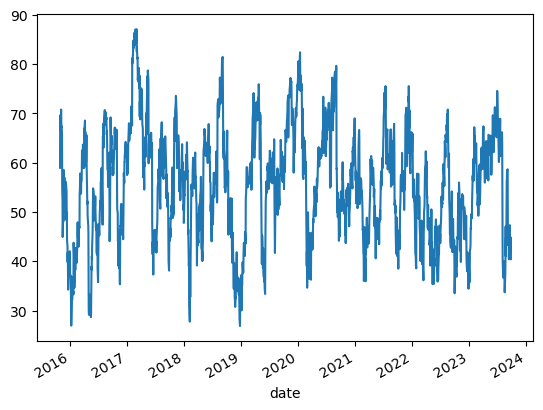

In [253]:
df.xs('AAPL',level=1)['rsi'].plot()

### 3 Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


In [269]:
# Define the last columns
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume','open',
                                                         'high','low','close']]

data=(pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                 df.unstack()[last_cols].resample('M').last().stack('ticker')],
                 axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          136.213760   39.086571 -1.033887  3.692471  3.547568   
           AAL        287.915798   39.429932  0.190822  3.827636  3.672028   
           AAPL      4029.441813   26.890560 -0.967900  3.369611  3.282983   
           ABBV       340.716427   40.770767 -0.526809  3.832284  3.735768   
           ABT        212.708745   38.483486 -1.064842  3.704588  3.660875   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983159   78.671936 -1.028320  4.464683  4.374104   
           ABNB      1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG        196.971017  108.026909 -0.436215  4.734007  4.653660   
           GEHC       212.350630   66.153511 -0.893478  4.270855  4.155782   
           KVUE       677.910279   20.218124 -0.899746  3.174263  3.024299   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.620020         -0.001902  0.567157  73.421344  
           AAL     3.749832         -0.000966 -0.418771  40.718976  
           AAPL    3.326297         -0.003209 -0.142789  55.537346  
           ABBV    3.784026         -0.056745  0.145677  49.376878  
           ABT     3.682732         -0.010572  0.335558  56.962569  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.419394         -0.000020 -1.534536  33.116253  
           ABNB    4.940924          0.000213 -0.037854  44.494127  
           CEG     4.693834          0.000171  0.366876  55.245465  
           GEHC    4.213319          0.000185 -1.116463  40.922327  
           KVUE    3.099281          0.000032 -1.435621  35.706310  

[46894 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [255]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'],axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134323  0.402199  3.706314  3.604673  3.655494   
           AAPL     26.248026 -1.038688  3.353305  3.295542  3.324423   
           ABBV     40.620964 -0.893132  3.870876  3.762524  3.816700   
           ABT      34.463531 -1.035224  3.660400  3.559438  3.609919   
           ACN     103.970665 -0.996806  4.664445  4.641169  4.652807   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292961  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.131596  62.203499  
           AAPL           -0.002384 -0.195978  49.891067  
           ABBV           -0.044217 -0.760594  27.477730  
           ABT            -0.006968 -0.650888  38.008853  
           ACN            -0.004320 -0.135456  53.823740  
...                             ...       ...        ...  
2023-09-30 WMT            -0.000011  0.399459  54.722557  
           XOM             0.000026  1.400623  59.440190  
           MRNA            0.000146 -0.376899  38.747314  
           UBER            0.000441 -0.133973  45.005268  
           ABNB            0.000213 -0.037854  44.494127  

[12516 rows x 8 columns]

### 4 Calculate Monthly Returns for different time horizons as features

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historial returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [267]:
g = df.xs('AAPL', level=1)

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                  .pct_change(lag)
                                  .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                         upper=x.quantile(1-outlier_cutoff)))
                                  .add(1)
                                  .pow(1/lag)
                                  .sub(1))
    return df

data = data.groupby(level=1, group_keys = False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2019-10-31 AAL      29.852554 -0.370748  3.481206  3.263377  3.372292   
           AAPL     60.329147 -0.584572  4.130524  4.008815  4.069670   
           ABBV     65.912010 -0.922143  4.215254  4.094782  4.155018   
           ABT      77.782280 -0.083318  4.376869  4.303476  4.340173   
           ACN     174.418015 -0.368351  5.184406  5.145063  5.164734   
...                       ...       ...       ...       ...       ...   
2023-09-30 WFC      40.009789 -0.558742  3.783384  3.702645  3.743015   
           WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292961  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2019-10-31 AAL             0.000296  1.115035  58.952265   0.114572   
           AAPL            0.000972  0.550930  68.908100   0.110684   
           ABBV           -0.013877  0.857006  70.480831   0.065900   
           ABT            -0.001978  0.031249  54.403466   0.003289   
           ACN            -0.001440 -0.530220  47.064214  -0.031886   
...                             ...       ...        ...        ...   
2023-09-30 WFC             0.000016 -0.282325  40.920284  -0.015500   
           WMT            -0.000011  0.399459  54.722557  -0.000676   
           XOM             0.000026  1.400623  59.440190   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2019-10-31 AAL      0.068893  -0.003775  -0.020137  -0.018144   -0.011810   
           AAPL     0.091660   0.054360   0.037773   0.047048    0.012026   
           ABBV     0.108023   0.066042   0.005284   0.003732    0.006402   
           ABT     -0.008089  -0.012222   0.009611   0.016558    0.017601   
           ACN     -0.030628  -0.011138   0.003210   0.022600    0.014688   
...                      ...        ...        ...        ...         ...   
2023-09-30 WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431   
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2019-10-31 AAL     1.691913  0.575672  0.802037  1.814113 -0.632923  
           AAPL    0.702511  0.451320  0.141317  1.250403 -1.719688  
           ABBV    0.774124 -1.326107  0.584451 -1.117937 -0.458889  
           ABT     0.916276 -0.444755 -0.620420 -0.063650  0.582175  
           ACN     0.951888 -0.316833 -0.594087  0.138985 -0.295567  
...                     ...       ...       ...       ...       ...  
2023-09-30 WFC     1.137639  0.314482  2.009075 -0.404336 -1.468840  
           WMT     0.740055 -0.261890 -0.522678 -0.126426  0.642627  
           XOM     1.005967 -1.051369  1.707834 -0.675678 -0.284026  
           MRNA    1.155154  0.762525 -1.165677  0.590306  0.993548  
           UBER    1.078922  1.162540 -0.257003 -1.482231 -0.450323  

[6370 rows x 19 columns]

### 5 Download Fama-French Factors and Calculate Rolling Factor Betas

* We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression
* The five Fama-French factors, namely "Market Riskj", "Size", "Value", "Operating Profitability", and "Investment" have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. hence, it is natural to include past factor exposures as financial features in modles.
* We can access the historical factor returns using the pandas-datareader and estimate histoprical exposures using the RollingOLS rolling linear regression.

In [257]:
factor_data = web.DataReader('F-F_research_Data_5_Factors_2x3',
                              'famafrench',
                              start='2010')[0].drop('RF',axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data

#join this data to month return

factor_data = factor_data.join(data['return_1m']).sort_index()

# double check with apple  as example
factor_data.xs('AAPL',level=1).head()


,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325,0.096808
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.020278
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,-0.015246
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010637
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185


In [258]:
# double check with microsoft as example
factor_data.xs('MSFT',level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325,0.116660
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.016984
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,0.016277
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,0.110708
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,-0.008415


* Filter out stocks with less than 10 months of data

In [259]:
# check how many months' data we have under each stocks
factor_data.groupby(level=1).size()

ticker
AAL     72
AAPL    72
ABBV    72
ABNB    10
ABT     72
        ..
WFC     72
WMT     72
WYNN    70
XOM     72
YUM      2
Length: 176, dtype: int64

In [260]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >=10]
valid_stocks

ticker
AAL     72
AAPL    72
ABBV    72
ABNB    10
ABT     72
        ..
WDC     56
WFC     72
WMT     72
WYNN    70
XOM     72
Length: 168, dtype: int64

In [261]:
# filt out stocks we are going to remove
# factor_data = factor_data[~factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# filt out stocks we are going to keep

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10302 rows x 6 columns]

* now we are ready to calculate the Rolling Factor Betas

In [262]:
betas = (factor_data.groupby(level=1,
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const',axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165644  0.267343  0.310367  0.106903
           WFC     1.121746  0.300520  2.061533 -0.439488 -1.517558
           WMT     0.700556 -0.315600 -0.413433 -0.142907  0.508471
           XOM     0.983510 -1.093759  1.756777 -0.640865 -0.368456

[10302 rows x 5 columns]

In [263]:
# we have to shift betas, because we only know the betas after the month end, after all data of the month observed.
# therefore, we will shift all betas one months forward before we join the batas to the data.

betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.504874 -0.411220 -0.481330  0.057087  0.943374
           VZ      0.302531 -0.212071  0.344588  0.318169  0.000828
           WFC     1.137639  0.314482  2.009075 -0.404336 -1.468840
           WMT     0.740055 -0.261890 -0.522678 -0.126426  0.642627
           XOM     1.005967 -1.051369  1.707834 -0.675678 -0.284026

[10302 rows x 5 columns]

In [270]:
# now the data is ready to joint the data

data = (data.join(betas.groupby('ticker').shift()))
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          136.213760   39.086571 -1.033887  3.692471  3.547568   
           AAL        287.915798   39.429932  0.190822  3.827636  3.672028   
           AAPL      4029.441813   26.890560 -0.967900  3.369611  3.282983   
           ABBV       340.716427   40.770767 -0.526809  3.832284  3.735768   
           ABT        212.708745   38.483486 -1.064842  3.704588  3.660875   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983159   78.671936 -1.028320  4.464683  4.374104   
           ABNB      1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG        196.971017  108.026909 -0.436215  4.734007  4.653660   
           GEHC       212.350630   66.153511 -0.893478  4.270855  4.155782   
           KVUE       677.910279   20.218124 -0.899746  3.174263  3.024299   

                     bb_mid  garman_klass_vol      macd        rsi  Mkt-RF  \
date       ticker                                                            
2015-11-30 A       3.620020         -0.001902  0.567157  73.421344     NaN   
           AAL     3.749832         -0.000966 -0.418771  40.718976     NaN   
           AAPL    3.326297         -0.003209 -0.142789  55.537346     NaN   
           ABBV    3.784026         -0.056745  0.145677  49.376878     NaN   
           ABT     3.682732         -0.010572  0.335558  56.962569     NaN   
...                     ...               ...       ...        ...     ...   
2023-09-30 OTIS    4.419394         -0.000020 -1.534536  33.116253     NaN   
           ABNB    4.940924          0.000213 -0.037854  44.494127     NaN   
           CEG     4.693834          0.000171  0.366876  55.245465     NaN   
           GEHC    4.213319          0.000185 -1.116463  40.922327     NaN   
           KVUE    3.099281          0.000032 -1.435621  35.706310     NaN   

                   SMB  HML  RMW  CMA  
date       ticker                      
2015-11-30 A       NaN  NaN  NaN  NaN  
           AAL     NaN  NaN  NaN  NaN  
           AAPL    NaN  NaN  NaN  NaN  
           ABBV    NaN  NaN  NaN  NaN  
           ABT     NaN  NaN  NaN  NaN  
...                ...  ...  ...  ...  
2023-09-30 OTIS    NaN  NaN  NaN  NaN  
           ABNB    NaN  NaN  NaN  NaN  
           CEG     NaN  NaN  NaN  NaN  
           GEHC    NaN  NaN  NaN  NaN  
           KVUE    NaN  NaN  NaN  NaN  

[46894 rows x 14 columns]

In [ ]:
# now fix the missing values
# the solution is to fill those NaN values with average of the respective factor,


factors = []